In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bossthanison/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [3]:
# instantiate CountVectorizer (with the default parameters)
vect = CountVectorizer()
vect.fit(simple_train)

# examine the fitted vocabulary
print(vect.get_feature_names_out())

['cab' 'call' 'me' 'please' 'tonight' 'you']


In [4]:
# transform training data into a 'document-term matrix'

simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [5]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [6]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [7]:
# check the type of the document-term matrix
type(simple_train_dtm)

scipy.sparse._csr.csr_matrix

In [8]:
# examine the sparse matrix contents
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


In [9]:
# example text for model testing
simple_test = ["please don't call me"]

In [10]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [11]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


In [12]:
# read file into pandas using a relative path
sms = pd.read_csv("../data/spam_data.csv")
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
sms.describe()

,label,message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [14]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    641  Please call our customer service representativ...    4

In [28]:
# convert label to a numerical variable
sms['label_num'] = sms['label'].replace({"ham":0, "spam":1})
sms.head()

,label,message,lebel_num,message_len,clean_msg,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...,1
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though,0


In [29]:
#Check len of message
sms['message_len'] = sms['message'].apply(lambda x: len(x))
sms.head()

,label,message,lebel_num,message_len,clean_msg,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...,1
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though,0


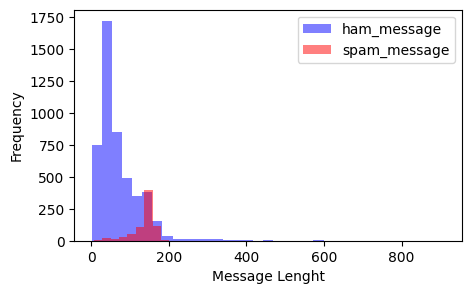

In [30]:
#Plot histogram of lenght message
plt.figure(figsize=(5, 3))
sms[sms['label']=='ham']['message_len'].plot(bins=35, kind="hist", color='blue',
                                             label='ham_message', alpha=0.5)

sms[sms['label']=='spam']['message_len'].plot(kind="hist", color='red',
                                             label='spam_message', alpha=0.5)

plt.legend()
plt.xlabel("Message Lenght")
plt.show()

In [31]:
sms[sms['label']=='ham'].describe()

,lebel_num,message_len,label_num
count,4825.0,4825.000000,4825.0
mean,0.0,71.448290,0.0
std,0.0,58.434864,0.0
min,0.0,2.000000,0.0
25%,0.0,33.000000,0.0
50%,0.0,52.000000,0.0
75%,0.0,93.000000,0.0
max,0.0,910.000000,0.0


In [32]:
sms[sms['label']=='spam'].describe()

,lebel_num,message_len,label_num
count,747.0,747.000000,747.0
mean,1.0,137.989290,1.0
std,0.0,29.980287,0.0
min,1.0,7.000000,1.0
25%,1.0,132.000000,1.0
50%,1.0,149.000000,1.0
75%,1.0,157.000000,1.0
max,1.0,223.000000,1.0


In [33]:
#Check 910 characters
sms[sms['message_len']==910]['message'].values[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [34]:
#create text preprocess function
def text_process(message):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in message if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = "".join(nopunc)

    # Now just remove any stopwords
    nostopword = " ".join([char for char in nopunc.split() if char.lower() not in STOPWORDS])

    return nostopword

In [35]:
sms['clean_msg'] = sms['message'].apply(text_process)
sms.head()

,label,message,lebel_num,message_len,clean_msg,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...,1
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though,0


In [36]:
#Count words of ham message
words = sms[sms['label']=='ham']['clean_msg'].apply(lambda x: x.lower().split())
ham_words = Counter()

for msg in words:
    ham_words.update(msg)

ham_words.most_common(5)

[('get', 303), ('ltgt', 276), ('ok', 273), ('go', 250), ('ill', 238)]

In [37]:
#Count words of spam message
words = sms[sms['label']=='spam']['clean_msg'].apply(lambda x: x.lower().split())
spam_words = Counter()

for msg in words:
    spam_words.update(msg)

spam_words.most_common(5)    

[('call', 344), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120)]

In [57]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms['clean_msg']
y = sms['label_num']
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [58]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f"Train shape : {X_train.shape}, {y_train.shape}")
print(f"Test shape : {X_test.shape}, {y_test.shape}")

Train shape : (4179,), (4179,)
Test shape : (1393,), (1393,)


In [59]:
# instantiate the vectorizer
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<4179x7974 sparse matrix of type '<class 'numpy.int64'>'
	with 34596 stored elements in Compressed Sparse Row format>

In [60]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7974 sparse matrix of type '<class 'numpy.int64'>'
	with 10279 stored elements in Compressed Sparse Row format>

In [66]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [67]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 2.33 ms, sys: 1.38 ms, total: 3.71 ms
Wall time: 2.52 ms


MultinomialNB()

In [69]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)
y_pred_class

array([0, 0, 0, ..., 0, 1, 0])

In [72]:
# calculate accuracy of class predictions
accuracy_score(y_test, y_pred_class)

0.9877961234745154

In [74]:
# print the confusion matrix
confusion_matrix(y_test, y_pred_class)

array([[1201,    7],
       [  10,  175]])

In [75]:
# print message text for false positives (ham incorrectly classifier)
X_test[y_pred_class > y_test]

4419                                        get free call
2340    Cheers message Zogtorius Ive staring phone ag...
2652                        Text get call phones problems
694               purchase stuff today mail po box number
2162                   replying boye changed phone number
2289                                        message offer
3415                                    pic Please resend
Name: clean_msg, dtype: object

In [76]:
# print message text for false negatives (spam incorrectly classifier)
X_test[y_pred_class < y_test]

3530    Xmas New Years Eve tickets sale club day 10am ...
1875         Would like see XXX pics hot nearly banned uk
717                                                 ERROR
1893    CALL 09090900040 LISTEN EXTREME DIRTY LIVE CHA...
4298    thesmszonecom lets send free anonymous masked ...
4949    Hi Amy sending free phone number couple days g...
2821    INTERFLORA Its late order Interflora flowers ...
191     unique enough Find 30th August wwwareyouunique...
2247    Hi ya babe x 4goten bout scammers getting smar...
4514                     Money wining number 946 wot next
Name: clean_msg, dtype: object

In [77]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([5.76526786e-03, 1.60207718e-04, 7.81761659e-02, ...,
       7.15740920e-09, 9.96492604e-01, 1.72697851e-08])

In [79]:
# calculate AUC
roc_auc_score(y_test, y_pred_prob)

0.9872785036692321

In [82]:
# create pipe
pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ("nb", MultinomialNB())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('nb', MultinomialNB())])

In [84]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
accuracy_score(y_test, y_pred)

0.9641062455132807

In [86]:
confusion_matrix(y_test, y_pred)

array([[1208,    0],
       [  50,  135]])

In [88]:
# instantiate a logistic regression model
logreg = LogisticRegression(solver='liblinear')

In [89]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 8.61 ms, sys: 1.01 ms, total: 9.62 ms
Wall time: 8.53 ms


LogisticRegression(solver='liblinear')

In [90]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [91]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01605213, 0.00776939, 0.01896046, ..., 0.01657867, 0.43962853,
       0.00498185])

In [92]:
# calculate accuracy
accuracy_score(y_test, y_pred_class)

0.9820531227566404

In [94]:
confusion_matrix(y_test, y_pred_class)

array([[1208,    0],
       [  25,  160]])

In [95]:
# calculate AUC
roc_auc_score(y_test, y_pred_prob)

0.993744406658314

In [96]:
# show default parameters for CountVectorizer
vect

CountVectorizer()

In [97]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

In [101]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
vect.fit(['this is a book', 'this is a cat'])
vect.get_feature_names_out()

array(['book', 'cat', 'is', 'is book', 'is cat', 'this', 'this is'],
      dtype=object)

In [102]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

In [103]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)